In [1]:
%autosave 60
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import deepcopy as copy

Autosaving every 60 seconds


If you download the code from github:

In [2]:
code_dir = '/Users/xychen/Documents/Astro/Code/s3fit/' # please change to your local path for the downloaded S3Fit directory

import sys, os
sys.path.append(os.path.abspath(code_dir)) 
from S3Fit.s3fit import FitFrame

If you install with pip:

In [3]:
# from s3fit import FitFrame

#### The example uses S3Fit v2.3

It is highly recommended to read the [manual](https://github.com/xychcz/S3Fit/blob/main/manuals/basic_usage.md) to learn about tht basic usage of S3Fit before running the example. \
It is also suggested to check the [full parameter list](https://github.com/xychcz/S3Fit/blob/main/manuals/full_parameter_list.md) 
and the [advanced usage](https://github.com/xychcz/S3Fit/blob/main/manuals/advanced_usage.md) if you try to customize the fitting.  

# 1. Example data

Input spectral data

In [4]:
example_spec_tw = fits.open('example_galaxy_spec_tw.fits')[0].data
spec_wave_w = example_spec_tw[0]
spec_flux_w = example_spec_tw[1]
spec_ferr_w = example_spec_tw[2]

spec_valid_range = [[4950, 5074], [5120, 5240], [5280, 6420], [6500, 10050]]
spec_R_inst_w = [7170, 631 / 0.31 * 0.5] # define spectral resolution in blaze wavelength 7170AA

v0_redshift = 0.4684 # a rough guess of systemic redshift

Input photometric data\
The default flux unit of `phot_flux_b` and `phot_ferr_b` is 'mJy'. Set `phot_fluxunit='erg/s/cm2/AA'` to use the unit of 'erg/s/cm2/AA'.

In [5]:
phot_name_b = np.array(['SDSS_up', 'SDSS_gp', 'SDSS_rp', 'SDSS_ip', 'SDSS_zp', '2MASS_J',
                        '2MASS_H', '2MASS_Ks', 'WISE_1', 'WISE_2', 'WISE_3', 'WISE_4'])
phot_flux_b = np.array([5.5153001e-02, 8.1697002e-02, 1.6868000e-01, 2.3030201e-01,
                        2.9083699e-01, 2.6506501e-01, 5.1317799e-01, 6.0935998e-01,
                        6.5717798e-01, 7.9932898e-01, 1.6560427e+01, 9.2305588e+01])
phot_ferr_b = np.array([5.37700020e-04, 7.42999837e-05, 7.90003687e-05, 1.22798607e-04,
                        1.38930045e-03, 4.11554985e-02, 2.27502026e-02, 1.14961006e-01,
                        2.30419636e-03, 2.99510360e-03, 3.06923389e-02, 3.02008629e-01])

phot_trans_dir='./filters' # you can download in https://github.com/xychcz/S3Fit/tree/main/filters

# 2. Set models

Use two-component SFH: exponential SFH for the `'main'` population and constant SFH for `'young'` population. These component names can be modified by user. \
For each component, `'pars'` lists the bounding conditions of each fitting parameters, i.e., \[min, max, tying condition\];
`'info'` lists the control conditions, which are fixed infomation in the fitting. \
Please read the [basic usage](https://github.com/xychcz/S3Fit/blob/main/manuals/basic_usage.md)
and the [advanced usage](https://github.com/xychcz/S3Fit/blob/main/manuals/advanced_usage.md)
to learn about the details of the setup. 

In [1]:
stellar_config = {'main' : {'pars': [[-1000, 1000, 'free'], # velocity shift (km/s)
                                     [  100, 1200, 'free'], # velocity FWHM (km/s)
                                     [    0,  5.0, 'free'], # extinction (AV)
                                     [    0, 0.94, 'free'], # CSP age of old population (or galaxy age) (log Gyr)
                                     [   -1,    1, 'free'], # declining timescale of exponential SFH (log Gyr)
                                    ],
                            'info': {'age_min' : -2.25,         # min SSP age (log Gyr)
                                     'age_max' : 'universe',    # max SSP age, can be either given in log Gyr, or in the universe age at the given v0_redshift
                                     'met_sel' : 'solar',       # metallicity, can be 'all', 'solar', or any combination of [0.004,0.008,0.02,0.05]
                                     'sfh_name': 'exponential', # name of SFH function, can be 'nonparametric', 'exponential', 'delayed', 'constant', or user defined function
                                    }
                           }, 
                  'young': {'pars': [[None, None, 'stellar:main:0'], # velocity shift (km/s)
                                     [None, None, 'stellar:main:1'], # velocity FWHM (km/s)
                                     [None, None, 'stellar:main:2'], # extinction (AV)
                                     [  -2,   -1, 'free'          ], # CSP age of young population (log Gyr). 'constant' SFH only has this parameter
                                    ], 
                            'info': {'age_min' : -2.25,      # min SSP age of young population (log Gyr)
                                     'age_max' : 0,          # max SSP age of young population (log Gyr)
                                     'met_sel' : 'solar', 
                                     'sfh_name': 'constant',
                                    } 
                           } 
                 }
ssp_file = './model_libraries/popstar_for_s3fit.fits' # SSP template file
# please use S3Fit/model_libraries/convert_popstar_ssp.py in the github page to create the ssp template library

Use three components of emssion lines, one for narrow lines and the other two for broad (outflow) lines. 
The lines for the 2nd outflow component are specified to the given transitions.\
Please read the [basic usage](https://github.com/xychcz/S3Fit/blob/main/manuals/basic_usage.md)
and the [advanced usage](https://github.com/xychcz/S3Fit/blob/main/manuals/advanced_usage.md)
to learn about other line setup, e.g., different line name presets (e.g., allowed or forbidden lines), emission or absorption, gaussian or lorentz profile. 

In [2]:
line_config = {'NLR'      : {'pars': [[ -500,   500, 'free'], # velocity shift (km/s)
                                      [  250,   750, 'free'], # velocity FWHM (km/s)
                                      [    0,     5, 'free'], # extinction (AV)
                                      [  1.3,   4.3, 'free'], # electron density (log cm-3)
                                      [    4,  None, 'fix' ], # electron temperature (log K)
                                     ],
                             'info': {'line_used': 'default'}
                            }, 
               'outflow_1': {'pars': [[-2000,   100, 'free'], 
                                      [  750,  2500, 'free'], 
                                      [    0,     5, 'free'], 
                                      [  1.3,   4.3, 'free'], 
                                      [    4,  None, 'fix' ],
                                     ], 
                             'info': {'line_used': 'default'}
                            }, 
               'outflow_2': {'pars': [[-3000, -2000, 'free'], 
                                      [  750,  2500, 'free'], 
                                      [    0,  None, 'fix' ], 
                                      [    2,  None, 'fix' ], 
                                      [    4,  None, 'fix' ],
                                     ], 
                             'info': {'line_used': ['[O III]:4960', '[O III]:5008', '[N II]:6550', 'Ha', '[N II]:6585']}
                            } 
            }

Set configurations for AGN UV/optical continuum (powerlaw is given here) and IR continuum (i.e., torus component). More detailed setups are given in [basic usage](https://github.com/xychcz/S3Fit/blob/main/manuals/basic_usage.md).

In [3]:
agn_config = {'main': {'pars': [[None, None, 'line:NLR:0;stellar:main:0'], # velocity shift (km/s), which is tied to NLR line or (secondary) stellar main component
                                [None, None, 'line:NLR:1;stellar:main:1'], # velocity FWHM (km/s)
                                [ 1.5, 10.0, 'free'], # extinction (AV)
                                [-1.7, None, 'fix']], # spectral index of powerlaw (alpha_lambda) at 0.1-5 micron
                       'info': {'mod_used': 'powerlaw'} } 
             }

torus_config = {'main': {'pars': [[None, None, 'line:NLR:0;stellar:main:0'], # velocity shift (km/s), which is tied to NLR line or (secondary) stellar main component
                                  [   3,   11, 'free'], # optical depth at 9.7 micron 
                                  [  10,   80, 'free'], # half-opening angle (degree) of torus
                                  [  10,   30, 'free'], # ratio of outer to inner radius
                                  [   0,   90, 'free']], # inclination angle (degree) from the polar direction
                         'info': {'mod_used': 'dust'} } # set 'mod_used' to ['disc', 'dust'] if use both of disc and dusty torus modules
               } 
torus_file = './model_libraries/skirtor_for_s3fit.fits'
# please use S3Fit/model_libraries/convert_skirtor_torus.py in the github page to create the torus library

Summarize configurations for all models. 
If a model is not required, e.g., AGN powerlaw is not required in this case since the example is type-2. 
you can comment this line or set `'enable': False`. \
Set `'use_pyneb': False` if PyNeb is not installed.

In [9]:
model_config = {'stellar': {'enable': True, 'config': stellar_config, 'file': ssp_file}, 
                'line'   : {'enable': True, 'config': line_config, 'use_pyneb': True}, 
                # 'agn'  : {'enable': True, 'config': agn_config}, 
                'torus'  : {'enable': True, 'config': torus_config, 'file': torus_file}}

# 3. Perform fitting with S<sup>3</sup>Fit

## 3.1 Pure spec fit

In the first case, we try the fitting only for spectral data. \
Starting from initializing the FitFrame.
- Set `num_mocks=0` to fit the original data only, i.e., no fitting is performed for mock spectra. \
- Set `plot_step=True` and `print_step=True` to trace the results in each step. \
- In this case, the examination of S/N of models and the updating of fitting are skipped. Please set `examine_result=True` if you want a more accurate fitting or to eliminate models with a low S/N. 

In [10]:
FF_noSED_biSFH = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, spec_R_inst_w=spec_R_inst_w, spec_valid_range=spec_valid_range, 
                          v0_redshift=v0_redshift, model_config=model_config,
                          num_mocks=0, fit_grid='log', examine_result=False, 
                          plot_step=True, print_step=True)

################################# S3Fit starts #################################
You are now using S3Fit v2.3.
############################# Initialize FitFrame ##############################
Perform fitting for the original data and 0 mock data.
[Note] The examination of S/N of models and the updating of fitting will be skipped since 'examine_result' is set to False.
Perform fitting in log space.
[Note] Pure line fitting (i.e., after subtracting continuum), if enabled, is always in linear space.
############################## Read spectral data ##############################
Mask out 347 data points with the input spec_valid_range.
[Note] A single value of spectral resolution 1017.742 is given at 7170.000AA.
[Note] Assume a linear wavelength-dependency of spectral resolution in the fitting.
Spectral fitting will be performed in wavelength range (rest frame, AA): from 3326.721 to 6934.477
[Note] The wavelength range is extended for tolerances of redshift of 0.4684+-0.0050 (+-1500 km/s)

Run the fit

####################### Loop 1/1 starts (original data) ########################
########################## Fit the original spectrum ###########################
Continuum models used in spectral fitting: stellar
Number of used CSP models: 2
#### <cont_fit_init> start: spectral fitting, initialize continuum models.
Perform Dual Annealing optimazation for a rough global search.
Fit with 2 free elements and 6 free parameters of 1 models, reduced chi-squared = 1.904.


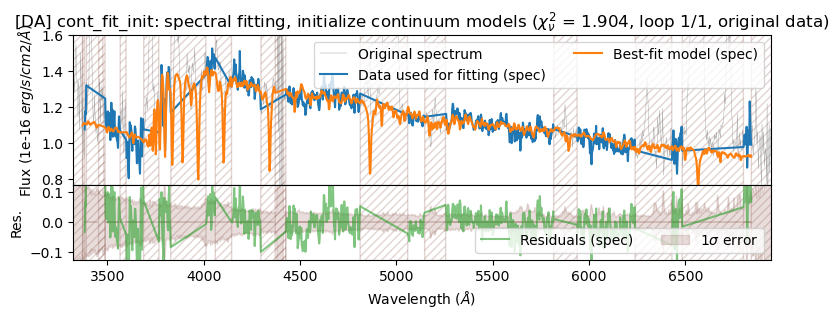

Perform Non-linear Least-square optimazation for fine tuning.
Fit with 2 free elements and 6 free parameters of 1 models, reduced chi-squared = 1.766.


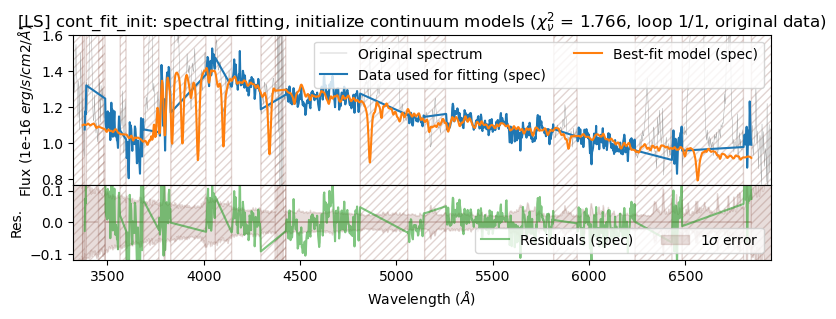

#### <cont_fit_init> finish: 1.8s/1.8s/1.8s spent in this step/loop/total.
#### <line_fit_init> start: spectral fitting, initialize emission lines.
Perform Dual Annealing optimazation for a rough global search.
Fit with 25 free elements and 10 free parameters of 1 models, reduced chi-squared = 4.617.


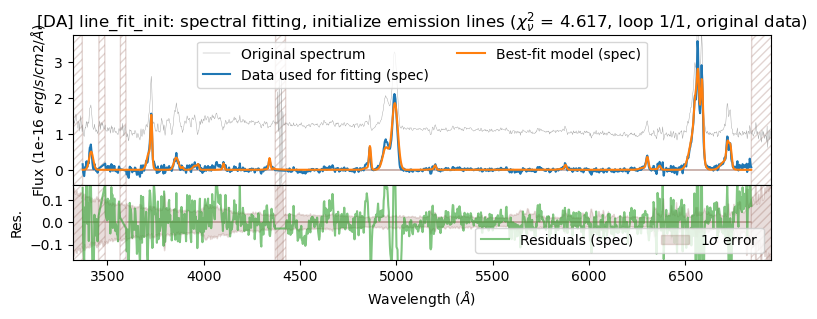

Perform Non-linear Least-square optimazation for fine tuning.
Fit with 25 free elements and 10 free parameters of 1 models, reduced chi-squared = 1.912.


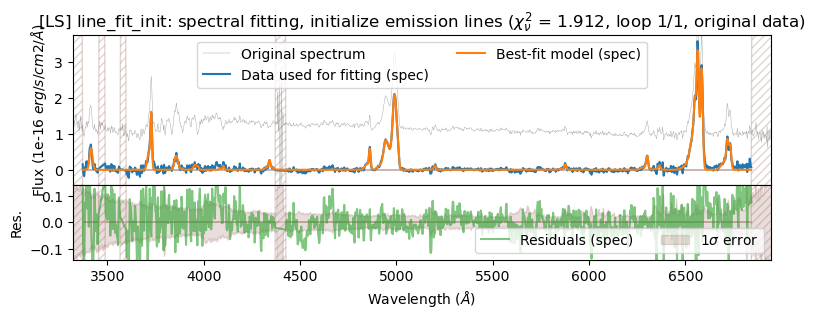

#### <line_fit_init> finish: 5.4s/7.2s/7.2s spent in this step/loop/total.
Number of used CSP models: 2
#### <cont_fit_1> start: spectral fitting, update continuum models.
Perform Dual Annealing optimazation for a rough global search.
Fit with 2 free elements and 6 free parameters of 1 models, reduced chi-squared = 2.196.


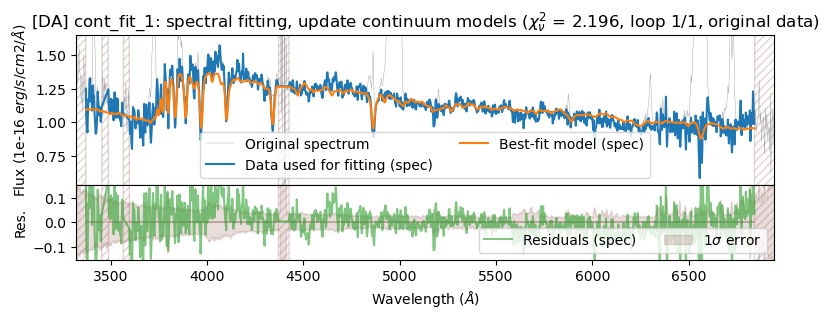

Perform Non-linear Least-square optimazation for fine tuning.
Fit with 2 free elements and 6 free parameters of 1 models, reduced chi-squared = 1.821.


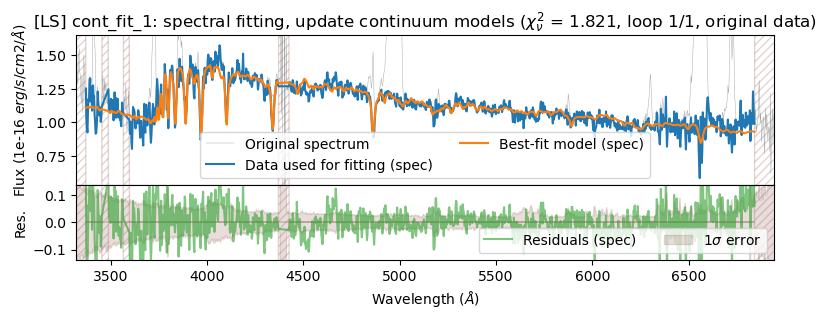

#### <cont_fit_1> finish: 2.2s/9.4s/9.4s spent in this step/loop/total.
#### <line_fit_1> start: spectral fitting, update emission lines.
Perform Dual Annealing optimazation for a rough global search.
Fit with 25 free elements and 10 free parameters of 1 models, reduced chi-squared = 1.993.


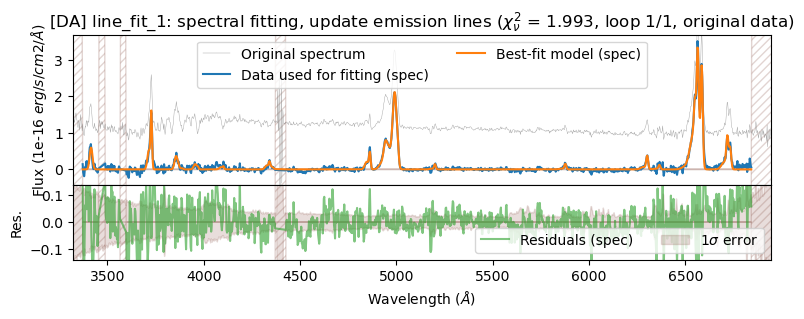

Perform Non-linear Least-square optimazation for fine tuning.
Fit with 25 free elements and 10 free parameters of 1 models, reduced chi-squared = 1.865.


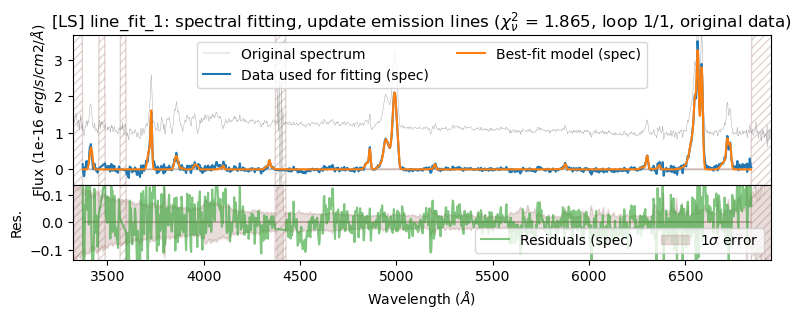

#### <line_fit_1> finish: 5.1s/14.5s/14.5s spent in this step/loop/total.
#### <joint_fit_1> start: spectral fitting, fit with all models.
Perturb transferred parameters with scatters of 2.0% of parameter ranges.
Perform Non-linear Least-square optimazation for fine tuning.
Non-linear fitting cycle 1/3, accept this fitting with chi_sq = 1.930 / 1.865 (goal) < 110%.
Fit with 27 free elements and 16 free parameters of 2 models, reduced chi-squared = 1.930.


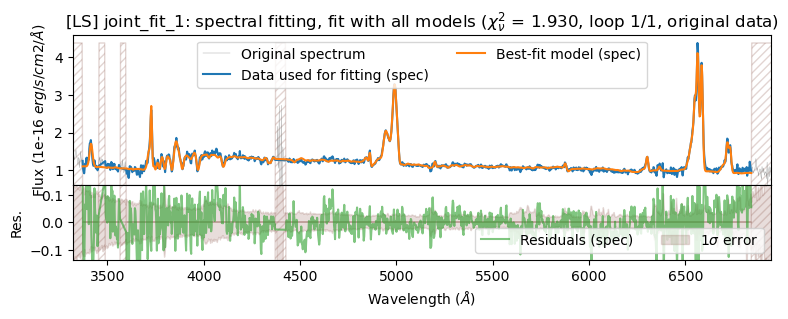

#### <joint_fit_1> finish: 6.5s/21.1s/21.1s spent in this step/loop/total.
##################### Loop 1/1 ends, chi_sq = 1.930 21.1s ######################
1 fitting loops (original data and 0 mock data) have good quality, with chi_sq = [1.93].
No fitting loop needs refitting. Run with main_fit(refit=True) to force refitting.
#################### 1 successful loops in 1 recyles, 21.1s ####################
The best-fit properties are extracted for the models: stellar+line

Best-fit stellar properties of the <main> component with exponential SFH.
| Redshift                                  =     0.4685 +/- 0.0000  |
| Velocity dispersion (σ,km/s)              =   322.3378 +/- 0.0000  |
| Extinction (AV)                           =     1.3853 +/- 0.0000  |
| Max age of composite star.pop. (log Gyr)  =     0.8093 +/- 0.0000  |
| Declining timescale of SFH (log Gyr)      =     0.8816 +/- 0.0000  |
| F5500 (rest,extinct) (1e-16 erg/s/cm2/Å)  =     0.1110 +/- 0.0000  |
| λL5500 (rest,intrinsi

In [11]:
FF_noSED_biSFH.main_fit()

## 3.2 Spec + SED fit

Now we try the simualtaneous fit for both of spectral and photometric SED.

In [18]:
FF_wSED_biSFH = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, spec_R_inst_w=spec_R_inst_w, spec_valid_range=spec_valid_range, 
                         phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                         v0_redshift=v0_redshift, model_config=model_config,
                         num_mocks=0, fit_grid='log', examine_result=True, 
                         print_step=True, plot_step=True)

################################# S3Fit starts #################################
You are now using S3Fit v2.3.
############################# Initialize FitFrame ##############################
Perform fitting for the original data and 0 mock data.
All continuum models and line components with peak S/N < 2 (set with 'accept_model_SN') will be automatically disabled in examination.
Perform fitting in log space.
[Note] Pure line fitting (i.e., after subtracting continuum), if enabled, is always in linear space.
############################## Read spectral data ##############################
Mask out 347 data points with the input spec_valid_range.
[Note] A single value of spectral resolution 1017.742 is given at 7170.000AA.
[Note] Assume a linear wavelength-dependency of spectral resolution in the fitting.
Spectral fitting will be performed in wavelength range (rest frame, AA): from 3326.721 to 6934.477
[Note] The wavelength range is extended for tolerances of redshift of 0.4684+-0.0050 (+

Here we use a matplotlib window to display the fitting result in each step dynamically. 

<IPython.core.display.Javascript object>


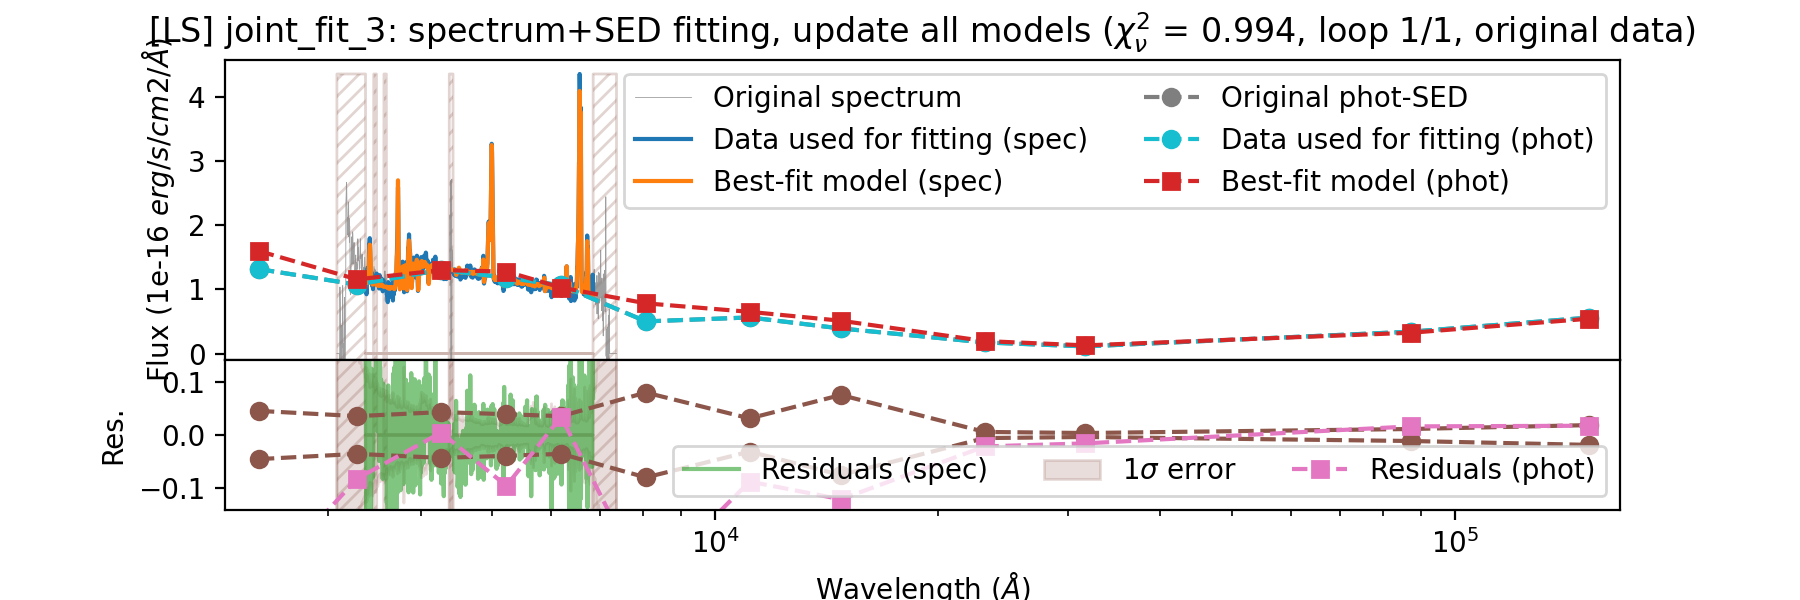

In [19]:
# switch on interactive mode; comment this magic command if you use ipython
%matplotlib notebook 

fig, axs = plt.subplots(2, 1, figsize=(9, 3), dpi=100, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(bottom=0.15, top=0.9, hspace=0, wspace=0)
plt.show()

FF_wSED_biSFH.canvas = (fig, axs)

Run the fit and the fitting plots will be updated dynamically in the above canvas.

In [20]:
FF_wSED_biSFH.main_fit() 

####################### Loop 1/1 starts (original data) ########################
########################## Fit the original spectrum ###########################
Continuum models used in spectral fitting: stellar
Number of used CSP models: 2
#### <cont_fit_init> start: spectral fitting, initialize continuum models.
Perform Dual Annealing optimazation for a rough global search.
Fit with 2 free elements and 6 free parameters of 1 models, reduced chi-squared = 2.215.
Perform Non-linear Least-square optimazation for fine tuning.
Fit with 2 free elements and 6 free parameters of 1 models, reduced chi-squared = 1.751.
#### <cont_fit_init> finish: 1.9s/1.9s/1.9s spent in this step/loop/total.
#### <line_fit_init> start: spectral fitting, initialize emission lines.
Perform Dual Annealing optimazation for a rough global search.
Fit with 25 free elements and 10 free parameters of 1 models, reduced chi-squared = 2.383.
Perform Non-linear Least-square optimazation for fine tuning.
Fit with 25 free

A scaled errors is used in the simultaneous spectrum+SED fitting. 
The scaled errors are calculated as $\sqrt{Em^2 + Ec^2}$, where `Em` and `Ec` are the original measurement errors and 
the calibration errors between different instruments. \
`Ec` is estimated as`ratio * flux`, where the `ratio` is initialized as 10% and refreshed 
to achieve a final reduced chi-squared of 1, i.e., a good fit. \
Please read the above running messages to check the updating of the ratio, 
and the chi-squared values based on the original and scaled errors, respectively. 

## 3.3 Spec + SED fit with mocked spectra (for uncertainty estimation)

Here we also run fitting for 10 mock data to estimate fitting uncertainties. \
The fitting for mock data could be run in multi threading if `use_multi_thread=True` (default is False). You can specify the used number of threads with `num_multi_threads`.\
The fitting status in each step can be hidden if `print_step=False`. \
If `keep_invalid=True`, the mock data and models will also be created in invalid wavelength range, e.g., as a reference to the low S/N data. Set `keep_invalid=False` (default) is you would like to save running time. 

In [76]:
FF_wSED_biSFH_mock10 = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, spec_R_inst_w=spec_R_inst_w, spec_valid_range=spec_valid_range, 
                                phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                                v0_redshift=v0_redshift, model_config=model_config,
                                num_mocks=10, # use_multi_thread=True, 
                                fit_grid='log', examine_result=False, keep_invalid=True, 
                                print_step=False, plot_step=True)

################################# S3Fit starts #################################
You are now using S3Fit v2.3.
############################# Initialize FitFrame ##############################
Perform fitting for the original data and 10 mock data.
[Note] The examination of S/N of models and the updating of fitting will be skipped since 'examine_result' is set to False.
Perform fitting in log space.
[Note] Pure line fitting (i.e., after subtracting continuum), if enabled, is always in linear space.
############################## Read spectral data ##############################
Mask out 347 data points with the input spec_valid_range.
[Note] A single value of spectral resolution 1017.742 is given at 7170.000AA.
[Note] Assume a linear wavelength-dependency of spectral resolution in the fitting.
Spectral fitting will be performed in wavelength range (rest frame, AA): from 3041.036 to 7459.558
[Note] The wavelength range is extended for tolerances of redshift of 0.4684+-0.0050 (+-1500 km/s

<IPython.core.display.Javascript object>


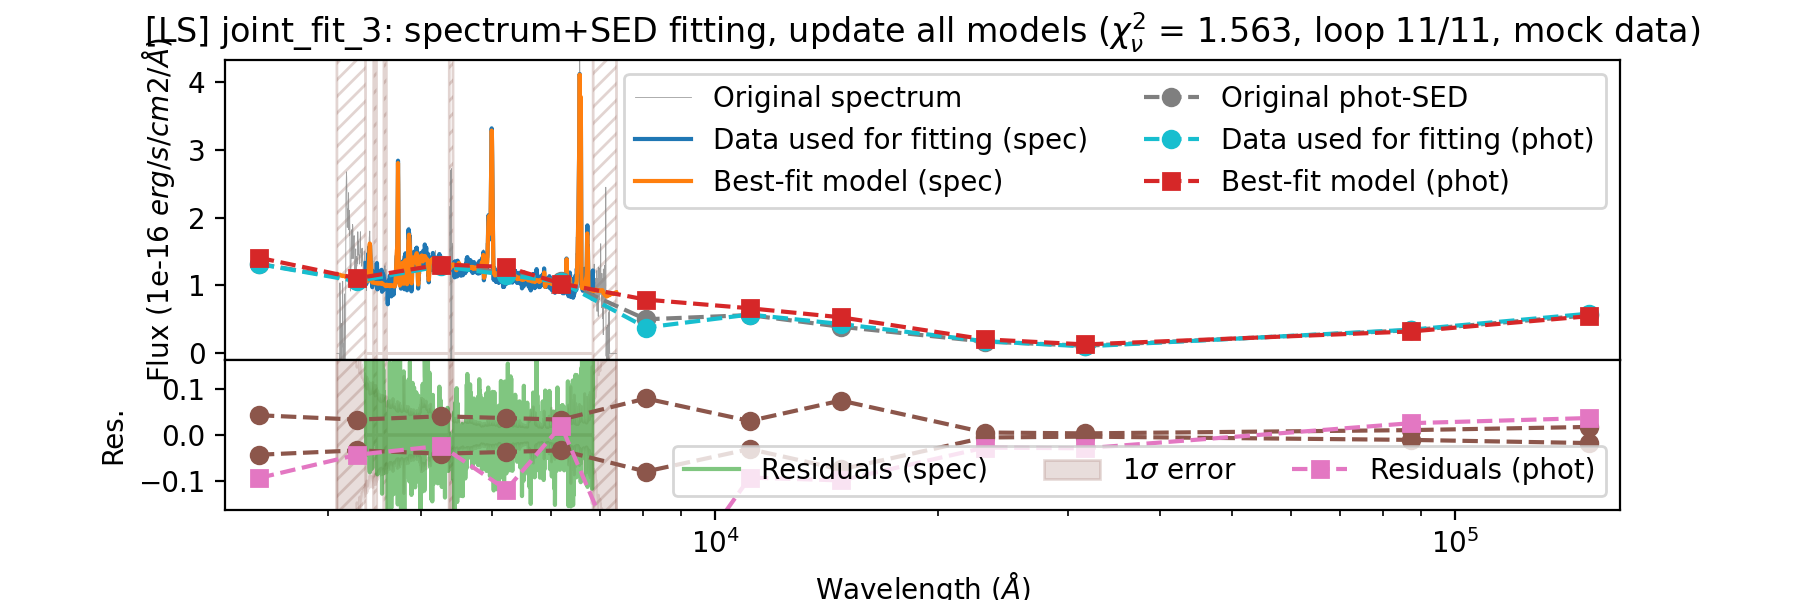

In [21]:
# switch on interactive mode; comment this magic command if you use ipython
%matplotlib notebook 

fig, axs = plt.subplots(2, 1, figsize=(9, 3), dpi=100, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(bottom=0.15, top=0.9, hspace=0, wspace=0)
plt.show()

FF_wSED_biSFH_mock10.canvas = (fig, axs)

In [22]:
FF_wSED_biSFH_mock10.main_fit()

####################### Loop 1/11 starts (original data) #######################
##################### Loop 1/11 ends, chi_sq = 1.006 36.7s #####################
######################### Loop 2/11 starts (mock data) #########################
##################### Loop 2/11 ends, chi_sq = 1.602 38.6s #####################
######################### Loop 3/11 starts (mock data) #########################
##################### Loop 3/11 ends, chi_sq = 1.498 32.8s #####################
######################### Loop 4/11 starts (mock data) #########################
##################### Loop 4/11 ends, chi_sq = 1.531 35.6s #####################
######################### Loop 5/11 starts (mock data) #########################
##################### Loop 5/11 ends, chi_sq = 1.454 33.0s #####################
######################### Loop 6/11 starts (mock data) #########################
##################### Loop 6/11 ends, chi_sq = 1.622 36.4s #####################
######################### Lo

In this fitting the running message is not shown with print_step=False, which may by helpful to reduce the length in the cell output in fitting with mocked spectra. You can reload the hidded running message by the following command:

In [47]:
# for message in FF_wSED_biSFH_mock10.log_message: print(message)

## 3.4 Spec + SED fit with non-parametric SFH

You may also run another fit with a different SFH, e.g., nonparametric SFH, by setting a new stellar_config and updating model_config.
The fitting status and plots in each step are hidden with `print_step=False` and `plot_step=False`.

In [77]:
model_npSFH_config = copy(model_config)
stellar_npSFH_config = {'main': {'pars': [[-1000, 1000, 'free'], [100, 1200, 'free'], [0, 5.0, 'free'], [-1, -1, 'fix'], [-1, -1, 'fix']], 
                             'info': {'age_min': -2.25, 'age_max': 'universe', 'met_sel': 'solar', 'sfh_name': 'nonparametric'} } }
model_npSFH_config['stellar'] = {'enable': True, 'config': stellar_npSFH_config, 'file': ssp_file}

FF_wSED_npSFH_mock10 = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, spec_R_inst_w=spec_R_inst_w, spec_valid_range=spec_valid_range, 
                                phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                                v0_redshift=v0_redshift, model_config=model_npSFH_config,
                                num_mocks=10, use_multi_thread=True, 
                                fit_grid='log', examine_result=False, 
                                print_step=False, plot_step=False)

################################# S3Fit starts #################################
You are now using S3Fit v2.3.
############################# Initialize FitFrame ##############################
Perform fitting for the original data and 10 mock data.
Perform fitting for the 10 mock data in multithreading with system available threads.
[Note] The examination of S/N of models and the updating of fitting will be skipped since 'examine_result' is set to False.
Perform fitting in log space.
[Note] Pure line fitting (i.e., after subtracting continuum), if enabled, is always in linear space.
############################## Read spectral data ##############################
Mask out 347 data points with the input spec_valid_range.
[Note] A single value of spectral resolution 1017.742 is given at 7170.000AA.
[Note] Assume a linear wavelength-dependency of spectral resolution in the fitting.
Spectral fitting will be performed in wavelength range (rest frame, AA): from 3326.721 to 6934.477
[Note] The 

In [24]:
FF_wSED_npSFH_mock10.main_fit()

####################### Loop 1/11 starts (original data) #######################
##################### Loop 1/11 ends, chi_sq = 1.026 81.4s #####################
######################### Loop 9/11 starts (mock data) #########################
######################### Loop 6/11 starts (mock data) #########################
######################### Loop 2/11 starts (mock data) #########################
######################## Loop 10/11 starts (mock data) #########################
######################### Loop 7/11 starts (mock data) #########################
######################## Loop 11/11 starts (mock data) #########################
######################### Loop 5/11 starts (mock data) #########################
######################### Loop 4/11 starts (mock data) #########################
######################### Loop 3/11 starts (mock data) #########################
######################### Loop 8/11 starts (mock data) #########################
#################### Loop 3/

In [26]:
# FF_wSED_npSFH_mock10.save_to_file("FF_wSED_npSFH_mock10.pkl.gz")
# FF_wSED_npSFH_mock10 = FitFrame()
# FF_wSED_npSFH_mock10.reload_from_file("FF_wSED_npSFH_mock10.pkl.gz")

# 4. Save the results to a file and reload from the file

With the following command, you can easily save the best-fitting results to a compressed pickle file. 

In [27]:
FF_wSED_biSFH_mock10.save_to_file("FF_wSED_biSFH_mock10.pkl.gz")

The input arguments, best-fit results, and running messages are saved to FF_wSED_biSFH_mock10.pkl.gz (a python pickle compressed with gzip).


You can reload the input arguments and best-fit results from the pickle file, and use them to recover a new `FitFrame`. 

In [44]:
FF_new = FitFrame()
FF_new.reload_from_file("FF_wSED_biSFH_mock10.pkl.gz")

[Note] Please input arguments or use FitFrame.reload() to initialize FitFrame.
FitFrame is reloaded from FF_wSED_biSFH_mock10.pkl.gz with the input arguments, best-fit results, and running messages.
################################# S3Fit starts #################################
You are now using S3Fit v2.3.
############################# Initialize FitFrame ##############################
Perform fitting for the original data and 10 mock data.
[Note] The examination of S/N of models and the updating of fitting will be skipped since 'examine_result' is set to False.
Perform fitting in log space.
[Note] Pure line fitting (i.e., after subtracting continuum), if enabled, is always in linear space.
############################## Read spectral data ##############################
Mask out 347 data points with the input spec_valid_range.
[Note] A single value of spectral resolution 1017.742 is given at 7170.000AA.
[Note] Assume a linear wavelength-dependency of spectral resolution in the fittin

You can re-open the running messages to check if there are any issues during the fitting processes. 

In [ ]:
# for message in FF_new.log_message: print(message)

# 5. Format of the output results

Here we use `FF_new` reloaded above for an example. \
S<sup>3</sup>Fit provides a nested dictionary, `FF_new.output_mc`, to display the results of the fitting. \
`FF_new.output_mc` can be calculated for the reloaded `FF_new` with the following command 
(the command is not required if you performa a new fitting by running `FF_new.main_fit()`). 

In [45]:
FF_new.extract_results(step='spec+SED', print_results=False)

Now you can view the results stored in `FF_new.output_mc`. 
Set `print_results=True` if you would like to print the best-fit properties of each model (default is `False`).\
In the above command, 
`step='spec+SED'` means the output results are from the simultaneous spectrum+SED fitting. You can change to `step='spec'` or `step='pure-spec'` to extract the results from the pure-spectrum fitting step (that provides better accuracy for emission lines, see following discussion in emisison line section), or obtain both of the results as follows:

In [62]:
output_spec_mc = FF_new.extract_results(step='pure-spec', return_results=True)
output_specSED_mc = FF_new.extract_results(step='spec+SED', return_results=True)

`FF_new.output_mc` contains the following main outputs in a given fitting step. 

- `FF_new.output_mc[mod][comp]['spec_lw']`\
The best-fit model spectra of the `comp` component of the `mod` model.\
For example, `FF_new.output_mc['stellar']['young']['spec_lw'][i_l,i_w]` 
shows the best-fit spectrum of the young stellar population at the `i_w`-th wavelength 
from the `i_l`-th fitting loop (`i_l=0` for the original data and `i_l>=1` for the mock data). 
Replace`'young'` to `'main'` to get the spectrum of the main population, 
or to `'sum'`  to obtain the sum of all stellar components. 
- `FF_new.output_mc[mod][comp]['sed_lw']`\
The best-fit model spectra of the `comp` component of the `mod` model.\
The difference the above two results is that  `'spec_lw'` returns the model spectra in the grid of the input spectral wavelength,
while `'sed_lw'` returns the model spectra in the full SED wavelength range to cover all the input photometric bands. 
Please refer to the following section to learn about examples to display these model spectra. 
- `FF_new.output_mc[mod][comp]['values'][val_name]`\
The calculated properties of the `comp` component of the `mod` model.\
For example, `FF_new.output_mc['stellar']['young']['values']['AV'][i_l]` returns the best-fit dust extinction of stellar continuum
of the young population from the `i_l`-th fitting loop. 
The lists of the names of models, components, and the available values can be obtained as:

In [48]:
for mod in FF_new.rev_model_type.split('+'):
    if mod == 'tot': continue
    comps = [*FF_new.output_mc[mod]]
    if len(comps) == 2: comps = comps[:-1] # do not show 'sum' if the model has only one component
    print(f">>>> '{mod}' model has components of '{comps}'\n List of value names: {[*FF_new.output_mc[mod][comps[0]]['values']]}")

>>>> 'stellar' model has components of '['main', 'young', 'sum']'
 List of value names: ['voff', 'fwhm', 'AV', 'sfh_par0', 'sfh_par1', 'redshift', 'flux_5500', 'loglambLum_5500', 'flux_wavenorm', 'loglambLum_wavenorm', 'logMass_formed', 'logMass_remaining', 'logMtoL', 'logAge_Lweight', 'logAge_Mweight', 'logZ_Lweight', 'logZ_Mweight']
>>>> 'torus' model has components of '['main']'
 List of value names: ['voff', 'opt_depth_9.7', 'opening_angle', 'radii_ratio', 'inclination', 'loglum']
>>>> 'line' model has components of '['NLR', 'outflow_1', 'outflow_2', 'sum']'
 List of value names: ['voff', 'fwhm', 'AV', 'e_den', 'e_temp', '[Ne V]:3427', '[O II]:3727', '[O II]:3730', '[Ne III]:3870', 'H8', '[Ne III]:3969', 'H7', 'Hd', 'Hg', '[O III]:4364', 'Hb', '[O III]:4960', '[O III]:5008', '[N I]:5199', '[N I]:5202', 'He I:5877', '[O I]:6302', '[O I]:6366', '[N II]:6550', 'Ha', '[N II]:6585', '[S II]:6718', '[S II]:6733']


Please read the following sections to learn about the details of these values. \
`FF_new.output_mc` also stores the direct outputs of S<sup>3</sup>Fit, such as:

- `FF_new.output_mc[mod][comp]['par_lp']`\
Best-fit model parameters (non-linear). \
Example: `FF_new.output_mc['stellar']['young']['par_lp'][i_l,i_p]` gives the best-fit `i_p`-th parameter (e.g., `i_p=0` for velocity shift) of the young stellar population in the `i_l`-th fitting loop. The parameters are sorted following the order specified in the input `model_config` dictionary. 
- `FF_new.output_mc[mod][comp]['coeff_le']`\
Best-fit model coefficients (linear), i.e., normalization factors of each model elements. \
Example: `FF_new.output_mc['line']['NLR']['coeff_le'][i_l,i_e]` gives the best-fit coefficient of the `i_e`-th model element of narrow component of emission line models in the `i_l`-th fitting loop. 
The values of the coefficients depends on how the models are normlized. 
For emssion line models, the coefficients are indeed the velocity-integrated line flux, in unit of the the input spectrum.\
The best-fit model spectra and valued properties are calculated from `par_lp` and `coeff_le`. 

Finally, `FF_new.output_mc` provides the best-fit spectra of total models in both of the ranges of the input spectrum or the full SED. They can be obtianed as follows. \
`_l` prefix denotes the fitting loop number, where `i_l=0` for the original data and `i_l>=1` for the mock data. \
`_w` and `_b` represent wavelength of spectrum or SED and bands photometric data points, respectively. \

- `FF_new.output_mc['tot']['fmod']['spec_lw'][i_l,i_w]`
- `FF_new.output_mc['tot']['fmod']['sed_lw'][i_l,i_w]`
- `FF_new.output_mc['tot']['fmod']['phot_lb'][i_l,i_b]`

You can replace `'fmod'` above with 
- `'flux'` to obtain the mock data created in each fitting loop;
- `'ferr'` to obtain the errors used in each fitting loop, which are the original measurement errors in the pure-spectral fitting step, or the scaled errors to account for the calibration errors across different instruments;
- `'fres'` to obtain fitting residuals, i.e., `'flux'-'fmod'` in each loop.

# 6. Display best-fit model spectra

In [49]:
# switch on interactive mode; comment this magic command if you use ipython
%matplotlib inline 

As mentioned above, the best-fit model spectra are stored in 
- `FF_new.output_mc[mod][comp]['spec_lw']` in the wavelength range of the input observed spectrum and 
- `FF_new.output_mc[mod][comp]['sed_lw']` in the wavelength range of the full SED to cover all input photometric data. \

`FF_new.output_mc[mod][comp]['spec_lw'][i_l,i_w]`shows the best-fit spectrum of the component `comp` of the model `mod`, 
at the `i_w`-th wavelength in the `i_l`-th loop. 
`i_l=0` corresponds to the best-fit result for the original data
and `i_l>=1` for mock data. \
`FF_new.output_mc[mod]['sum']['spec_lw']` shows the sum of all components of the model `mod`.\
`FF_new.output_mc['tot']['fmod']['spec_lw']` shows the total model spectra of all models.\
You can check all available model components with the following command.

In [50]:
print("All available model components:")
for mod in FF_new.rev_model_type.split('+'):
    print(f"Model '{mod}' has components: {[*FF_new.output_mc[mod]][:-1]}")

All available model components:
Model 'stellar' has components: ['main', 'young']
Model 'torus' has components: ['main']
Model 'line' has components: ['NLR', 'outflow_1', 'outflow_2']


You can also plot \
`FF_new.output_mc['tot']['flux']['spec_lw'][i_l]` for the original data if `i_l=0` or mock data if `i_l>=1`; \
`FF_new.output_mc['tot']['ferr']['spec_lw'][i_l]` for the original measurement errors if you specify `step='spec'` above; 
or the scaled errors accounting for calibration uncertainties if you specify `step='spec+SED'`;\
`FF_new.output_mc['tot']['fres']['spec_lw'][i_l]` for the fitting residuals. \
Please replace `'spec_lw'` with `'sed_lw'` or `'phot_lb'` for spectra in the SED range and the corresponding photometric data points. \
The original fluxes and errors of the input spectrum and photometric data are also stored in: \
`FF_new.spec['flux_w']` = `FF_new.output_mc['tot']['flux']['spec_lw'][0]`\
`FF_new.spec['ferr_w']` = `FF_new.output_mc['tot']['ferr']['spec_lw'][0]`\
`FF_new.phot['flux_b']` = `FF_new.output_mc['tot']['flux']['phot_lb'][0]`\
`FF_new.phot['ferr_b']` = `FF_new.output_mc['tot']['ferr']['phot_lb'][0]`

Firstly we show the spectra in the wavelength range of the input spectrum. Define a factor `tmp_z` to determine whether to show the results in the observed frame or the rest frame. 

In [63]:
# tmp_z = 1  # show in observed wavelength
tmp_z = (1+FF_new.v0_redshift)  # show in rest wavelength

Text(0.5, 0, 'Rest wavelength ($\\AA$)')

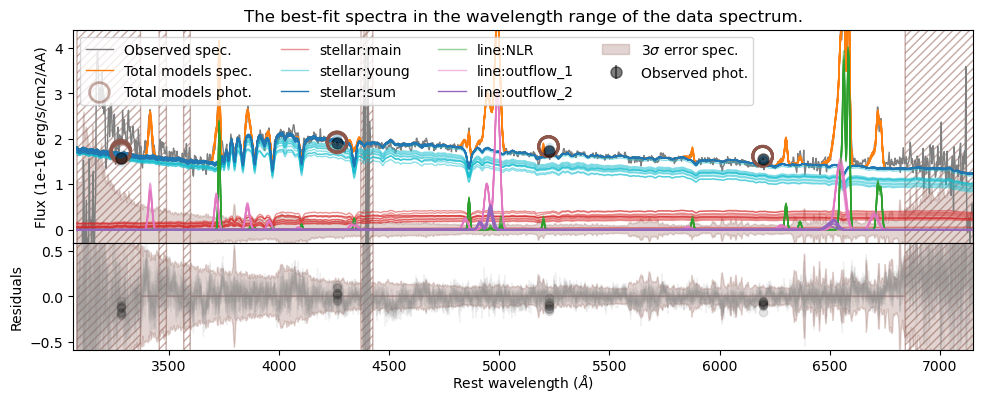

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), dpi=100, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(bottom=0.12, top=0.92, left=0.08, right=0.98, hspace=0, wspace=0)
ax1, ax2 = axs

#####################
# plot original data
ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.spec['flux_w']*tmp_z , c='C7', linewidth=1, label='Observed spec.')
ax1.errorbar(FF_new.phot['wave_b']/tmp_z, FF_new.phot['flux_b']*tmp_z, 
             FF_new.phot['ferr_b']*tmp_z*3, fmt='o', markersize=8, color='k', alpha=.5, label='Observed phot.', zorder=20)
#####################

#####################
# plot model spectra
for i_loop in range(FF_new.num_loops): 
    line, = ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc['tot']['fmod']['spec_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C1', alpha=1)
    if i_loop == 0: line.set_label('Total models spec.')
        
for i_loop in range(FF_new.num_loops):
    line = ax1.scatter(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['fmod']['phot_lb'][i_loop]*tmp_z, 
                        marker='o', color='None', ec='C5', alpha=0.5, s=200, linewidth=2, zorder=20)
    if i_loop == 0: line.set_label('Total models phot.')
        
mod = 'stellar'
for (i_comp, (color, alpha)) in enumerate(zip(['C3','C9','C0'],[0.5,0.5,1])):
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['spec_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
            
mod = 'line' # here we hide total emission line spectra
for (i_comp, (color, alpha)) in enumerate(zip(['C2','C6','C4'],[0.5,0.5,1])): 
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['spec_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
#####################

#####################
# plot residuals
for i_loop in range(FF_new.num_loops): 
    line, = ax2.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc['tot']['fres']['spec_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C7', alpha=0.1)
    if i_loop == 0: line.set_label('Residuals')
    ax2.plot(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['fres']['phot_lb'][i_loop]*tmp_z, 'o', color='k', alpha=0.1)
    ax1.plot(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['flux']['phot_lb'][i_loop]*tmp_z, 'o', color='C0', alpha=0.1)
#####################

#####################
# plot original spectral errors and invalid range
for ax in axs:
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -3*FF_new.spec['ferr_w']*tmp_z, 3*FF_new.spec['ferr_w']*tmp_z, 
                     fc='C5', ec='C5', alpha=0.25, label=r'3$\sigma$ error spec.')
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -1*~FF_new.spec['mask_valid_w'], 10*~FF_new.spec['mask_valid_w'], 
                     hatch='////', fc='None', ec='C5', alpha=0.5) # show the masked out range
    ax.set_xlim(4.5e3/tmp_z,1.05e4/tmp_z)
#####################

ax1.legend(ncol=4, loc=2)
ax1.set_ylim(-0.2*tmp_z,3*tmp_z); ax2.set_ylim(-0.4*tmp_z,0.4*tmp_z)
ax1.tick_params(axis='x', which='both', labelbottom=False)
ax1.set_title('The best-fit spectra in the wavelength range of the data spectrum.')
ax1.set_ylabel(f'Flux ({FF_new.spec_flux_scale} erg/s/cm2/AA)')
ax2.set_ylabel(f'Residuals')
ax2.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)

Now we zoom-out in a wider range and show wavelength in log grid. 

Text(0.5, 0, 'Rest wavelength ($\\AA$)')

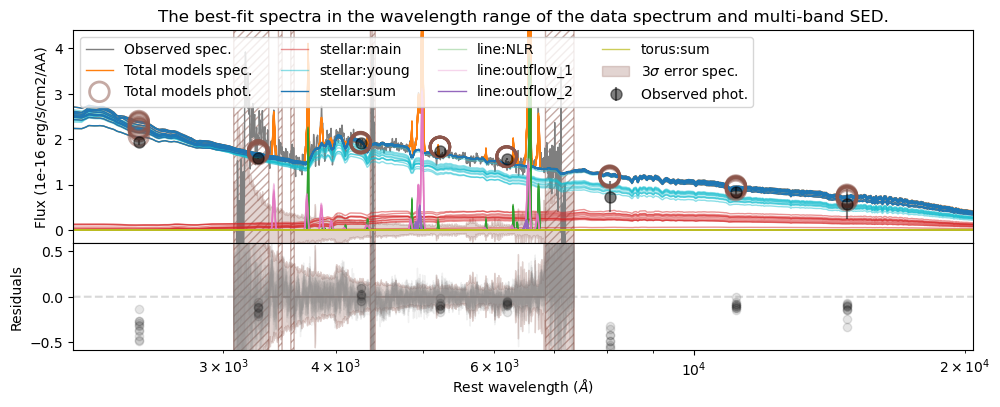

In [65]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), dpi=100, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(bottom=0.12, top=0.92, left=0.08, right=0.98, hspace=0, wspace=0)
ax1, ax2 = axs

#####################
# plot original data
ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.spec['flux_w']*tmp_z , c='C7', linewidth=1, label='Observed spec.')
ax1.errorbar(FF_new.phot['wave_b']/tmp_z, FF_new.phot['flux_b']*tmp_z, 
             FF_new.phot['ferr_b']*tmp_z*3, fmt='o', markersize=8, color='k', alpha=.5, label='Observed phot.', zorder=20)
#####################

#####################
# plot model spectra
for i_loop in range(FF_new.num_loops): 
    line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc['tot']['fmod']['sed_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C1', alpha=1)
    if i_loop == 0: line.set_label('Total models spec.')
        
for i_loop in range(FF_new.num_loops): 
    line = ax1.scatter(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['fmod']['phot_lb'][i_loop]*tmp_z, 
                        marker='o', color='None', ec='C5', alpha=0.5, s=200, linewidth=2, zorder=20)
    if i_loop == 0: line.set_label('Total models phot.')
        
mod = 'stellar'
for (i_comp, (color, alpha)) in enumerate(zip(['C3','C9','C0'],[0.5,0.5,1])):
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['sed_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
            
mod = 'line' # here we hide total emission line spectra
for (i_comp, (color, alpha)) in enumerate(zip(['C2','C6','C4'],[0.3,0.3,1])): 
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['sed_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
            
mod = 'torus'
for i_loop in range(FF_new.num_loops): 
    line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod]['sum']['sed_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C8', alpha=.75)
    if i_loop == 0: line.set_label(mod+':sum')
#####################

#####################
# plot residuals
for i_loop in range(FF_new.num_loops): 
    line, = ax2.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc['tot']['fres']['spec_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C7', alpha=0.1)
    if i_loop == 0: line.set_label('Residuals')
    ax2.plot(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['fres']['phot_lb'][i_loop]*tmp_z, 'o', color='k', alpha=0.1)
ax2.plot(FF_new.sed['wave_w']/tmp_z, FF_new.sed['wave_w']*0, '--', c='C7', alpha=.3)
#####################

#####################
# plot original spectral errors and invalid range
for ax in axs:
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -3*FF_new.spec['ferr_w']*tmp_z, 3*FF_new.spec['ferr_w']*tmp_z, 
                     fc='C5', ec='C5', alpha=0.25, label=r'3$\sigma$ error spec.')
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -1*~FF_new.spec['mask_valid_w'], 10*~FF_new.spec['mask_valid_w'], 
                     hatch='////', fc='None', ec='C5', alpha=0.5) # show the masked out range
    ax.set_xlim(3e3/tmp_z,3e4/tmp_z); ax.set_xscale('log')
#####################

ax1.legend(ncol=4, loc=2)
ax1.set_ylim(-0.2*tmp_z,3*tmp_z); ax2.set_ylim(-0.4*tmp_z,0.4*tmp_z)
ax1.tick_params(axis='x', which='both', labelbottom=False)
ax1.set_title('The best-fit spectra in the wavelength range of the data spectrum and multi-band SED.')
ax1.set_ylabel(f'Flux ({FF_new.spec_flux_scale} erg/s/cm2/AA)')
ax2.set_ylabel(f'Residuals')
ax2.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)

And finally show the results in the full SED range. 

Text(0.5, 0, 'Rest wavelength ($\\AA$)')

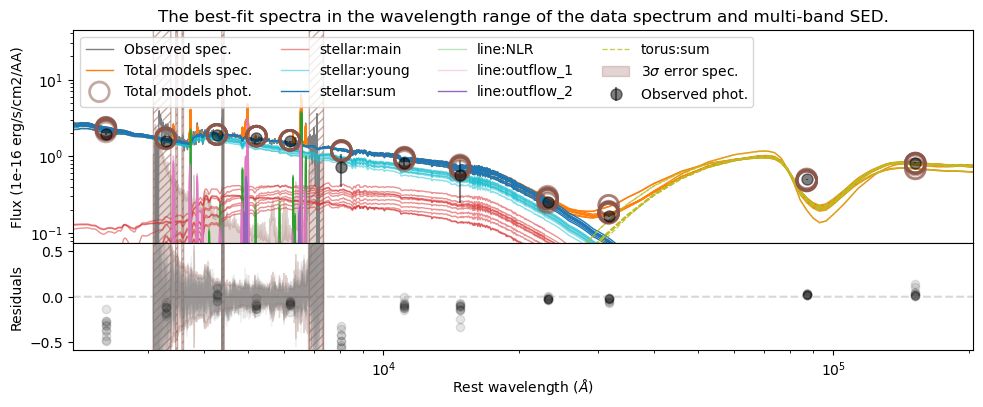

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), dpi=100, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(bottom=0.12, top=0.92, left=0.08, right=0.98, hspace=0, wspace=0)
ax1, ax2 = axs

#####################
# plot original data
ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.spec['flux_w']*tmp_z , c='C7', linewidth=1, label='Observed spec.')
ax1.errorbar(FF_new.phot['wave_b']/tmp_z, FF_new.phot['flux_b']*tmp_z, 
             FF_new.phot['ferr_b']*tmp_z*3, fmt='o', markersize=8, color='k', alpha=.5, label='Observed phot.', zorder=20)
#####################

#####################
# plot model spectra

for i_loop in range(FF_new.num_loops): 
    line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc['tot']['fmod']['sed_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C1', alpha=1)
    if i_loop == 0: line.set_label('Total models spec.')
        
for i_loop in range(FF_new.num_loops): 
    line = ax1.scatter(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['fmod']['phot_lb'][i_loop]*tmp_z, 
                        marker='o', color='None', ec='C5', alpha=0.5, s=200, linewidth=2, zorder=20)
    if i_loop == 0: line.set_label('Total models phot.')

mod = 'stellar'
for (i_comp, (color, alpha)) in enumerate(zip(['C3','C9','C0'],[0.5,0.5,1])):
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['sed_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
            
mod = 'line' # here we hide total emission line spectra
for (i_comp, (color, alpha)) in enumerate(zip(['C2','C6','C4'],[0.3,0.3,1])): 
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['sed_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
            
mod = 'torus'
for i_loop in range(FF_new.num_loops): 
    line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod]['sum']['sed_lw'][i_loop]*tmp_z, 
                     '--', linewidth=1, color='C8', alpha=.75)
    if i_loop == 0: line.set_label(mod+':sum')
#####################

#####################
# plot residuals
for i_loop in range(FF_new.num_loops): 
    line, = ax2.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc['tot']['fres']['spec_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C7', alpha=0.1)
    if i_loop == 0: line.set_label('Residuals')
    ax2.plot(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['fres']['phot_lb'][i_loop]*tmp_z, 'o', color='k', alpha=0.1)
ax2.plot(FF_new.sed['wave_w']/tmp_z, FF_new.sed['wave_w']*0, '--', c='C7', alpha=.3)
#####################

#####################
# plot original spectral errors and invalid range
for ax in axs:
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -3*FF_new.spec['ferr_w']*tmp_z, 3*FF_new.spec['ferr_w']*tmp_z, 
                     fc='C5', ec='C5', alpha=0.25, label=r'3$\sigma$ error spec.')
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -1*~FF_new.spec['mask_valid_w'], 1e2*~FF_new.spec['mask_valid_w'], 
                     hatch='////', fc='None', ec='C5', alpha=0.5) # show the masked out range
    ax.set_xlim(3e3/tmp_z,3e5/tmp_z); ax.set_xscale('log'); 
#####################

ax1.legend(ncol=4, loc=2)
ax1.set_ylim(0.05*tmp_z,30*tmp_z); ax1.set_yscale('log')
ax2.set_ylim(-0.4*tmp_z,0.4*tmp_z)
ax1.tick_params(axis='x', which='both', labelbottom=False)
ax1.set_title('The best-fit spectra in the wavelength range of the data spectrum and multi-band SED.')
ax1.set_ylabel(f'Flux ({FF_new.spec_flux_scale} erg/s/cm2/AA)')
ax2.set_ylabel(f'Residuals')
ax2.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)

The default output spectra of S<sup>3</sup>Fit are in spectral density per wavelength. 
If you want to display the spectra in spectral density per frequency, you can re-extract the best-fit results to return `'Fnu'`:

In [67]:
FF_new.extract_results(step='spec+SED', flux_type='Fnu')

/var/folders/_0/x8322vzn24q3l6s445j80_t00000gn/T/ipykernel_85459/1412990054.py:51: RuntimeWarning: divide by zero encountered in divide
  line, = ax2.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc['tot']['fres']['spec_lw'][i_loop]/FF_new.spec['flux_w'],
/var/folders/_0/x8322vzn24q3l6s445j80_t00000gn/T/ipykernel_85459/1412990054.py:61: RuntimeWarning: divide by zero encountered in divide
  ax.fill_between(FF_new.spec['wave_w']/tmp_z, -3*FF_new.spec['ferr_w']/FF_new.spec['flux_w'], 3*FF_new.spec['ferr_w']/FF_new.spec['flux_w'],


Text(0.5, 0, 'Rest wavelength ($\\AA$)')

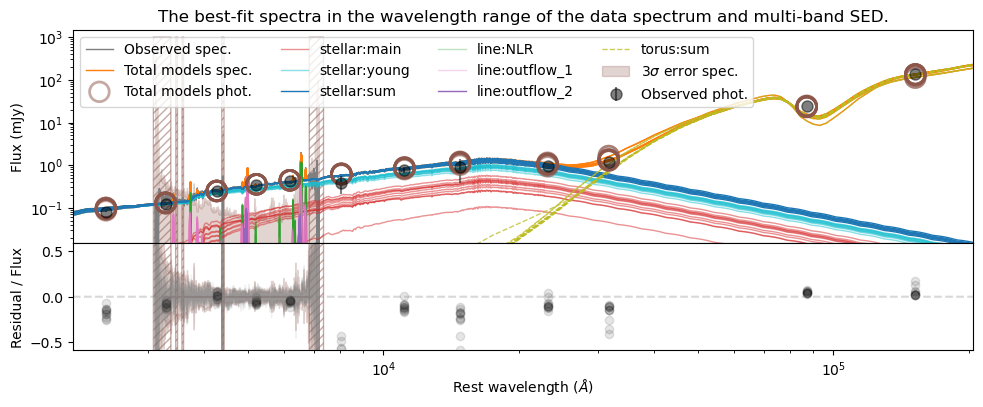

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), dpi=100, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(bottom=0.12, top=0.92, left=0.08, right=0.98, hspace=0, wspace=0)
ax1, ax2 = axs

#####################
# plot original data
ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.spec['flux_w']*tmp_z , c='C7', linewidth=1, label='Observed spec.')
ax1.errorbar(FF_new.phot['wave_b']/tmp_z, FF_new.phot['flux_b']*tmp_z, 
             FF_new.phot['ferr_b']*tmp_z*3, fmt='o', markersize=8, color='k', alpha=.5, label='Observed phot.', zorder=20)
#####################

#####################
# plot model spectra

for i_loop in range(FF_new.num_loops): 
    line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc['tot']['fmod']['sed_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C1', alpha=1)
    if i_loop == 0: line.set_label('Total models spec.')
        
for i_loop in range(FF_new.num_loops): 
    line = ax1.scatter(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['fmod']['phot_lb'][i_loop]*tmp_z, 
                        marker='o', color='None', ec='C5', alpha=0.5, s=200, linewidth=2, zorder=20)
    if i_loop == 0: line.set_label('Total models phot.')

mod = 'stellar'
for (i_comp, (color, alpha)) in enumerate(zip(['C3','C9','C0'],[0.5,0.5,1])):
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['sed_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
            
mod = 'line' # here we hide total emission line spectra
for (i_comp, (color, alpha)) in enumerate(zip(['C2','C6','C4'],[0.3,0.3,1])): 
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['sed_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
            
mod = 'torus'
for i_loop in range(FF_new.num_loops): 
    line, = ax1.plot(FF_new.sed['wave_w']/tmp_z, FF_new.output_mc[mod]['sum']['sed_lw'][i_loop]*tmp_z, 
                     '--', linewidth=1, color='C8', alpha=.75)
    if i_loop == 0: line.set_label(mod+':sum')
#####################

#####################
# plot residuals
for i_loop in range(FF_new.num_loops): 
    line, = ax2.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc['tot']['fres']['spec_lw'][i_loop]/FF_new.spec['flux_w'], 
                     '-', linewidth=1, color='C7', alpha=0.1)
    if i_loop == 0: line.set_label('Residual/Flux')
    ax2.plot(FF_new.phot['wave_b']/tmp_z, FF_new.output_mc['tot']['fres']['phot_lb'][i_loop]/FF_new.phot['flux_b'], 'o', color='k', alpha=0.1)
ax2.plot(FF_new.sed['wave_w']/tmp_z, FF_new.sed['wave_w']*0, '--', c='C7', alpha=.3)
#####################

#####################
# plot original spectral errors and invalid range
for ax in axs:
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -3*FF_new.spec['ferr_w']/FF_new.spec['flux_w'], 3*FF_new.spec['ferr_w']/FF_new.spec['flux_w'], 
                     fc='C5', ec='C5', alpha=0.25, label=r'3$\sigma$ error spec.')
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -1*~FF_new.spec['mask_valid_w'], 1e3*~FF_new.spec['mask_valid_w'], 
                     hatch='////', fc='None', ec='C5', alpha=0.5) # show the masked out range
    ax.set_xlim(3e3/tmp_z,3e5/tmp_z); ax.set_xscale('log'); 
#####################

ax1.legend(ncol=4, loc=2)
ax1.set_ylim(0.01*tmp_z,1000*tmp_z); ax1.set_yscale('log')
ax2.set_ylim(-0.4*tmp_z,0.4*tmp_z)
ax1.tick_params(axis='x', which='both', labelbottom=False)
ax1.set_title('The best-fit spectra in the wavelength range of the data spectrum and multi-band SED.')
ax1.set_ylabel(f'Flux (mJy)')
ax2.set_ylabel(f'Residual / Flux')
ax2.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)

In examples above, the best-fit model spectra from all fitting loops for mock data is displayed. 
If you only would like to show the model spectra for the fitting of the original data, 
please replace loops starting by `for i_loop in range(FF_new.num_loops)` 
with `i_loop = 0`. 

# 7. Print and retrieve properties of best-fit models

## 7.1 Stellar continuum models

You can print best-fit results of stellar components with different SFH functions. \
Set `show_average=True` to print the average values of each properties in the fitting loops, 
or `show_average=False` to print the value from the fitting of the original data (i.e., the 0th loop). 

In [78]:
mod = 'stellar'
output_stellar_c = FF_new.model_dict[mod]['spec_mod'].extract_results(ff=FF_new, step='spec+SED', 
                                                                      print_results=True, return_results=True, show_average=True)


Best-fit stellar properties of the <main> component with exponential SFH.
| Redshift                                  =     0.4685 +/- 0.0001  |
| Velocity dispersion (σ,km/s)              =   346.7129 +/- 33.5424 |
| Extinction (AV)                           =     1.2054 +/- 0.1180  |
| Max age of composite star.pop. (log Gyr)  =     0.4391 +/- 0.2551  |
| Declining timescale of SFH (log Gyr)      =     0.0143 +/- 0.5786  |
| F5500 (rest,extinct) (1e-16 erg/s/cm2/Å)  =     0.0403 +/- 0.0141  |
| λL5500 (rest,intrinsic) (log Lsun)        =    10.9498 +/- 0.2312  |
| Mass (all formed) (log Msun)              =    11.1255 +/- 0.2057  |
| Mass (remaining) (log Msun)               =    10.9715 +/- 0.1862  |
| Mass/λL5500 (log Msun/Lsun)               =     0.0217 +/- 0.2463  |
| λL5500-weight age (log Gyr)               =     0.0910 +/- 0.4153  |
| Mass-weight age (log Gyr)                 =     0.2441 +/- 0.3413  |
| λL5500-weight metallicity (log Z)         =    -1.6990 +/- 0.0000  |
| 

Results are stored in the returned dictionary `output_stellar_c` (you can also retrieve using `FF_new.output_mc['stellar']`). \
`output_stellar_c` has is a nested dictionary with the following items:
- `output_stellar_c[comp]['par_lp']`, the best-fit model parameters (non-linear), and 
`output_stellar_c[comp]['coeff_le']`, the best-fit model coefficients (linear), i.e., normalization factors of each model elements. 
Please read Section 5. Format of the output results to learn about the meannings of non-linear parameters and linear coefficients. 
You may omit them and focus on the following `'values'` dictionary for a basic usage. 

- `output_stellar_c[comp]['values'][val_name]`, the calculated properties of the `comp` component of `stellar` model.\
For example, `output_stellar_c['young']['values']['AV'][i_l]` returns the best-fit dust extinction of young stellar population
from the `i_l`-th fitting loop. \
You can use `output_stellar_c['sum']['values'][val_name]` to obtain the properties of the sum of all stellar components, e.g., the total stellar mass. 

The list of the names of the available properties for each component can be obtained as:

In [79]:
print(f"List of value names for the stellar components {[*output_stellar_c][:-1]}: \n{[*output_stellar_c[[*output_stellar_c][0]]['values']]}")

List of value names for the stellar components ['main', 'young']: 
['voff', 'fwhm', 'AV', 'sfh_par0', 'sfh_par1', 'redshift', 'flux_5500', 'loglambLum_5500', 'flux_wavenorm', 'loglambLum_wavenorm', 'logMass_formed', 'logMass_remaining', 'logMtoL', 'logAge_Lweight', 'logAge_Mweight', 'logZ_Lweight', 'logZ_Mweight']


Meanings of each properties:
- `'voff'` and `'fwhm'`: velocity shift and dispersion (in FWHM) of stellar continua, in unit of km/s. The dispersion is corrected for instrumental broadening. 
- `'AV'`: extinction of stellar continua. 
- `'sfh_par0'` and `'sfh_par1'`: SFH parameters.  `'sfh_par0'` is the age of composite stellar population (except for nonparametric SFH), in log Gyr. 
The meaning of `'sfh_par1'` depends on which SFH function you use. 
In this example, the main population use exponentially declined SFH and `'sfh_par1'` is the declined timescale in log Gyr. 
You may obtain `'sfh_par2'` or more if such parameters are required in a user-custom SFH function. 
- `'redshift'`: systemic redshift estimated from velocity shift. 
- `'flux_5500'` and `'loglambLum_5500'`: 
flux (F<sub>λ</sub>) and luminosity (λL<sub>λ</sub>) at the rest 5500AA. 
F<sub>λ</sub> is the extinct value in unit of factor x erg/s/cm2/AA, where the scaling factor can be obtain with `FF_new.spec_flux_scale`. 
λL<sub>λ</sub> is the intrinsic value in unit of log Lsun. 
- `'flux_wavenorm'` and `'loglambLum_wavenorm'`: 
flux (F<sub>λ</sub>) and luminosity (λL<sub>λ</sub>) at the user given normlized wavelength (set by `norm_wave` in FitFrame initialization).
- `'logMass_formed'` and `'logMass_remaining'`: total mass of stars formed in SFH and those remain in the current epoch, in unit of log Msun. 
- `'logMtoL'`: mass to luminosity (λL<sub>λ</sub>) ratio, in unit of log(Msun/Lsun). 
- `'logAge_Lweight'` and `'logAge_Mweight'`: luminosity- and mass-weight stellar age, in unit of log Gyr. 
- `'logZ_Lweight'` and `'logZ_Mweight'`: luminosity- and mass-weight metallicity, in unit of log Z. 

In [80]:
# example
print(f"Best-fit redshift from stellar continuum: {output_stellar_c['main']['values']['redshift'].mean():.5f} +- "+
      f"{output_stellar_c['main']['values']['redshift'].std():.5f}")
print(f"Best-fit total stellar mass (log Msun): {output_stellar_c['sum']['values']['logMass_remaining'].mean():.5f} +- "+
      f"{output_stellar_c['sum']['values']['logMass_remaining'].std():.5f}")

Best-fit redshift from stellar continuum: 0.46850 +- 0.00009
Best-fit total stellar mass (log Msun): 11.14693 +- 0.14158


### 7.1.1 Display and retrieve star formation history

You can plot the reconctructed SFH with a binning in log time. 
`num_bins` is the number of bins in the entire age range of popstar library.
The dashed (left) curves and light color bars (right) are results in each mock fitting loop.
The solid (left) and dark color bars (right) are averaged results. 

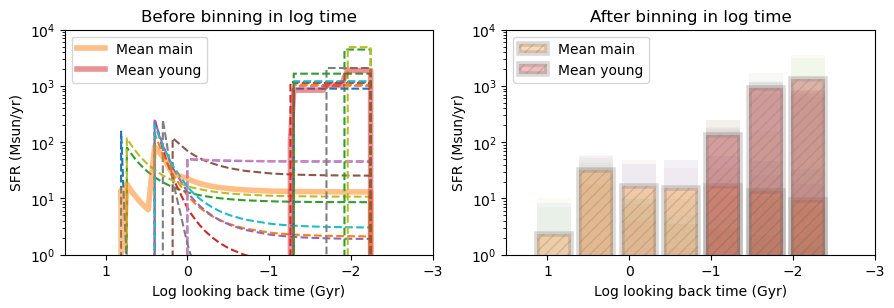

In [60]:
FF_new.model_dict['stellar']['spec_mod'].reconstruct_sfh(num_bins=10)

You can retrieve the values of SFH with the commands:

In [45]:
SFH_lcza, age_a = FF_new.model_dict['stellar']['spec_mod'].reconstruct_sfh(return_sfh=True, plot=False) # before binning
SFH_lczb, age_b = FF_new.model_dict['stellar']['spec_mod'].reconstruct_sfh(return_sfh=True, plot=False, num_bins=10) # after binning

`SFH_lcza[i_l, i_c, i_z, :]` shows the SFH with the `i_z`-th metallicity of the 
`i_c`-th components (`i_c=0` for main and `i_c=1` for young populations in this case) 
in the `i_l`-th fitting loop.
`_a` and `_b` represents the original ages and the binned ages, in log Gyr. 
Popstar SSP has four metallicities:

In [61]:
print('Available metallicities (Z):', np.unique(FF_new.model_dict['stellar']['spec_mod'].met_e))

Available metallicities (Z): [0.004 0.008 0.02  0.05 ]


### 7.1.2 Another example with nonparametric SFH

Here we print results of stellar components from the fitting with nonparametric SFH. 

In [28]:
FF_wSED_npSFH_mock10.extract_results(step='spec+SED', print_results=False)

The flux fraction of the dominated SSP is listed in the following table. 

In [29]:
mod = 'stellar'
FF_wSED_npSFH_mock10.model_dict[mod]['spec_mod'].extract_results(ff=FF_wSED_npSFH_mock10, step='spec+SED', 
                                                                 print_results=True, return_results=False, show_average=True)


Best-fit single stellar populations (SSP) of nonparametric SFH
---------------------------------------------------------------------------
|  ID  | Age (Gyr)  | Metallicity | Coeff.mean | Coeff.rms | log(M/L5500) |
---------------------------------------------------------------------------
| 0236 |   0.0060   |    0.0200   |   0.0873   |   0.1006  |    2.3740    |
| 0237 |   0.0065   |    0.0200   |   0.2753   |   0.1111  |    2.3581    |
| 0244 |   0.0085   |    0.0200   |   0.0521   |   0.0948  |    2.4315    |
| 0245 |   0.0087   |    0.0200   |   0.2419   |   0.0921  |    2.4809    |
| 0276 |   0.0550   |    0.0200   |   0.1137   |   0.0994  |    3.0160    |
---------------------------------------------------------------------------
[Note] Coeff is the normalized fraction of the intrinsic flux at rest 5500 AA.
[Note] only SSPs with flux fraction over 5% are listed.

Best-fit stellar properties of the <main> component with nonparametric SFH.
| Redshift                              

And plot the best-fit SFH:

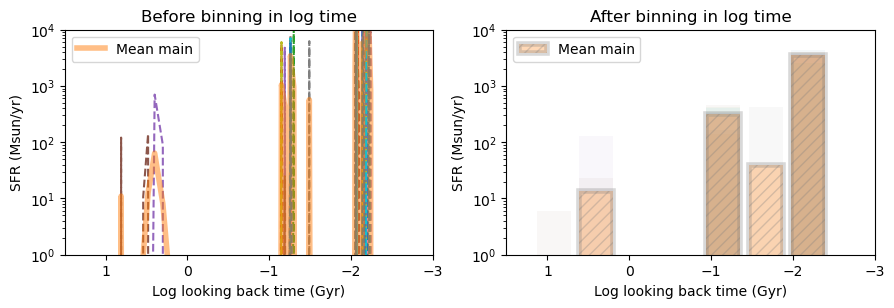

In [55]:
FF_wSED_npSFH_mock10.model_dict['stellar']['spec_mod'].reconstruct_sfh(num_bins=10)

Please follow the first case (i.e., `FF_new`) to obtain the output values of properties and SFH functions for `FF_wSED_npSFH_mock10`.

## 7.2 Emission lines

Here we print best-fit results of emission lines of different components. 
The following two commands display the results from the pure-spectral fitting 
and spectrum+SED fitting, respectively. 
Since the errors are scaled to account for calibration errors among instruments
in the spectrum+SED fitting, the created mock data has a larger scatter, 
which lead to larger uncertainties for the properties compared to pure-spectral fitting
(e.g., velocity shift of narrow line component, i.e., NLR). 
\
Set `show_average=True` to print the average values of each properties in the fitting loops, 
or `show_average=False` to print the value from the fitting of the original data (i.e., the 0th loop). 

In [30]:
mod = 'line'
output_line_spec_c = FF_new.model_dict[mod]['spec_mod'].extract_results(ff=FF_new, step='spec', 
                                                                        print_results=True, return_results=True)


Best-fit emission line components
|    Par/Line Name     |        NLR         |     outflow_1      |     outflow_2      |
|     Voff (km/s)      | -  26.36 +-   2.01 | - 996.26 +-   9.57 | -2482.36 +- 109.53 |
|     FWHM (km/s)      |   566.81 +-   9.29 |  1475.01 +-  36.10 |  2161.11 +- 139.95 |
|  AV (Balmer decre.)  |     2.72 +-   0.13 |     1.60 +-   0.41 |     0.00 +-   0.00 |
| log e-density (cm-3) |     2.66 +-   0.08 |     1.30 +-   0.61 |     2.00 +-   0.00 |
| log e-temperature(K) |     4.00 +-   0.00 |     4.00 +-   0.00 |     4.00 +-   0.00 |
|     [Ne V]:3427      |     0.00 +-   0.03 |    16.44 +-   0.95 |     0.00 +-   0.00 |
|     [O II]:3727      |    10.65 +-   0.50 |     6.20 +-   0.88 |     0.00 +-   0.00 |
|     [O II]:3730      |    10.66 +-   0.54 |     9.07 +-   1.08 |     0.00 +-   0.00 |
|    [Ne III]:3870     |     0.32 +-   0.45 |    11.22 +-   0.62 |     0.00 +-   0.00 |
|          H8          |     0.42 +-   0.02 |     0.47 +-   0.07 |     0.00 +-   0.00

In [31]:
mod = 'line'
output_line_specSED_c = FF_new.model_dict[mod]['spec_mod'].extract_results(ff=FF_new, step='spec+SED', 
                                                                           print_results=True, return_results=True)


Best-fit emission line components
|    Par/Line Name     |        NLR         |     outflow_1      |     outflow_2      |
|     Voff (km/s)      | -  26.31 +-   4.77 | -1025.20 +-  18.46 | -2799.77 +-  55.96 |
|     FWHM (km/s)      |   572.91 +-   7.96 |  1551.94 +-  51.07 |  1774.15 +- 161.54 |
|  AV (Balmer decre.)  |     2.83 +-   0.18 |     2.05 +-   0.48 |     0.00 +-   0.00 |
| log e-density (cm-3) |     2.60 +-   0.20 |     1.30 +-   0.92 |     2.00 +-   0.00 |
| log e-temperature(K) |     4.00 +-   0.00 |     4.00 +-   0.00 |     4.00 +-   0.00 |
|     [Ne V]:3427      |     0.00 +-   0.11 |    16.89 +-   1.70 |     0.00 +-   0.00 |
|     [O II]:3727      |    10.33 +-   0.72 |     6.23 +-   1.72 |     0.00 +-   0.00 |
|     [O II]:3730      |    10.77 +-   0.82 |     9.13 +-   1.83 |     0.00 +-   0.00 |
|    [Ne III]:3870     |     0.55 +-   0.30 |    12.14 +-   1.28 |     0.00 +-   0.00 |
|          H8          |     0.43 +-   0.02 |     0.42 +-   0.08 |     0.00 +-   0.00

Hereafter we adopt the results from the pure-spectral fitting step.

In [58]:
output_line_c = output_line_spec_c

Results are stored in the returned dictionary `output_line_c` (you can also retrieve using `FF_new.output_mc['line']`). 
`output_line_c` has is a nested dictionary with the same structure of `output_stellar_c` shown above. \
The list of the names of the available properties for each component can be obtained as:

In [59]:
print(f"List of value names for the emission line components {[*output_line_c][:-1]}: \n{[*output_line_c[[*output_line_c][0]]['values']]}")

List of value names for the emission line components ['NLR', 'outflow_1', 'outflow_2']: 
['voff', 'fwhm', 'AV', 'e_den', 'e_temp', '[Ne V]:3427', '[O II]:3727', '[O II]:3730', '[Ne III]:3870', 'H8', '[Ne III]:3969', 'H7', 'Hd', 'Hg', '[O III]:4364', 'Hb', '[O III]:4960', '[O III]:5008', '[N I]:5199', '[N I]:5202', 'He I:5877', '[O I]:6302', '[O I]:6366', '[N II]:6550', 'Ha', '[N II]:6585', '[S II]:6718', '[S II]:6733']


Meanings of each properties:
- `'voff'` and `'fwhm'`: velocity shift and dispersion (in FWHM) of each line, in unit of km/s. The line width is corrected for instrumental broadening. 
- `'AV'`: extinction estimated from Balmer decrement. 
- `'e_den'` and `'e_temp'`: log electron density (cm-3) and temperature (K). 
- other values with the line name: the observed (i.e., extinct) flux of each line in unit of factor x erg/s/cm2, where the scaling factor can be obtain with `FF_new.spec_flux_scale`. 

In [60]:
# example
print(f"Best-fit velocity FWHM of narrow line component (km/s): {output_line_c['NLR']['values']['fwhm'].mean():.5f} +- "+
      f"{output_line_c['NLR']['values']['fwhm'].std():.5f}")
print(f"Best-fit flux of narrow Halpha ({FF_new.spec_flux_scale} erg/s/cm2) : {output_line_c['NLR']['values']['Ha'].mean():.5f} +- "+
      f"{output_line_c['NLR']['values']['Ha'].std():.5f}")

Best-fit velocity FWHM of narrow line component (km/s): 578.05232 +- 9.28627
Best-fit flux of narrow Halpha (1e-16 erg/s/cm2) : 50.69515 +- 2.12119


### 7.2.1 Line tying relations

In order to reduce the effect of blurring of neighboring emission lines and the contamination of absorption features in stellar continuum, 
S<sup>3</sup>Fit ties the flux ratio of neighboring line doublets 
and Balmer lines. 
The ratios are calculated using pyneb with AV, electron density, and temperature (fixed to 10000 K in this fitting) of each line component.\
The tying relations are summarized in the infomation listed in the FitFrame initialization. \
The following example shows the line ratios of the best-fit narrow component. 

In [61]:
comp = 'NLR'
AV = output_line_c[comp]['values']['AV'][0]
e_den = output_line_c[comp]['values']['e_den'][0]
e_temp = output_line_c[comp]['values']['e_temp'][0]

line_mod = FF_new.model_dict['line']['spec_mod']
line_mod.update_lineratio(AV=AV, logden=e_den, logtem=e_temp)

print(f'Line ratios under the best-fit AV = {AV:.3f}, e- density = {10**e_den:.0f} cm-3, and the fixed e- temperature = {10**e_temp:.0f} K.')
for tied_name in line_mod.linelink_dict:
    i_tied = np.where(line_mod.linename_n == tied_name)[0][0]
    # read flux ratio for given logden and logtem
    ref_name = line_mod.linelink_dict[tied_name]['ref_name']
    print(f'The flux of {tied_name} is tied to {ref_name} with a ratio of {line_mod.lineratio_n[i_tied]:0.4f}.')

Line ratios under the best-fit AV = 2.722, e- density = 457 cm-3, and the fixed e- temperature = 10000 K.
The flux of Hb is tied to Ha with a ratio of 0.1577.
The flux of Hg is tied to Ha with a ratio of 0.0533.
The flux of Hd is tied to Ha with a ratio of 0.0249.
The flux of H7 is tied to Ha with a ratio of 0.0139.
The flux of H8 is tied to Ha with a ratio of 0.0086.
The flux of [O II]:3727 is tied to [O II]:3730 with a ratio of 0.9989.
The flux of [Ne III]:3969 is tied to [Ne III]:3870 with a ratio of 0.3248.
The flux of [O III]:4960 is tied to [O III]:5008 with a ratio of 0.3262.
The flux of [N I]:5199 is tied to [N I]:5202 with a ratio of 1.1235.
The flux of [O I]:6366 is tied to [O I]:6302 with a ratio of 0.3275.
The flux of [N II]:6550 is tied to [N II]:6585 with a ratio of 0.3354.
The flux of [S II]:6718 is tied to [S II]:6733 with a ratio of 1.0923.


## 7.3 AGN torus 

Similar to stellar continuum models and emision line models, you can print and retrieve best-fit results of AGN torus component 
as follows:

In [32]:
mod = 'torus'
output_torus_c = FF_new.model_dict[mod]['spec_mod'].extract_results(ff=FF_new, step='spec+SED', 
                                                                    print_results=True, return_results=True, show_average=True)


Best-fit properties of torus component: <main>
[Note] velocity shift (i.e., redshift) is tied following the input model_config.
| Optical depth at 9.7 um =    10.9952 +/- 0.0153  |
| Out/in radii ratio      =    28.4922 +/- 1.3363  |
| Half OpenAng (degree)   =    77.2094 +/- 7.7528  |
| Inclination (degree)    =    84.5490 +/- 11.5632 |
| log Lum of torus (Lsun) =    12.7771 +/- 0.0864  |


In [63]:
print(f"List of value names for the AGN torus components {[*output_torus_c][:-1]}: \n{[*output_torus_c[[*output_torus_c][0]]['values']]}")

List of value names for the AGN torus components ['main']: 
['voff', 'opt_depth_9.7', 'opening_angle', 'radii_ratio', 'inclination', 'loglum']


Meanings of each properties:
- `'voff'`: velocity shift in unit of km/s. It is used to control the redshifting of torus spectrum, and is always tied to other models, e.g., narrow lines. 
- `'opt_depth_9.7'`: optical depth of the Silicate 9.7 micron feature. 
- `'opening_angle'`: half openning angle of torus. 
- `'radii_ratio'`: the ratio of radii of outer to inner torus boundaries. 
- `'inclination'`: inclination of line of sight, 0 degree for a face-on view (type-1) and 90 degree for an edge-on view (type-2). \
Please check https://sites.google.com/site/skirtorus/sed-library to learn about details of the torus structure. 
- `'loglum'`: integrated luminosity of torus component, in unit of log Lsun. 